# Bluecoats Phase 1: Program Evaluation - Staff Engagement
### Openness to interviews and response content
#### Question: Will people talk to the blue coats and, if they do, will they provide infromation allowing us to identify, tangible, feasibly solvable problems? 
* Yes, there are a significant number of responses and common recurring themes.


<u>**Bluecoats Service Data - Analysis Questions**</u>

**General questions we want to be able to answer using “Service data”:**
* Are people engaging with bluecoats? 
* Do any people REALLY like to engage with us? 
* Who is engaging with bluecoats? 
* Are some roles/shifts more likely to engage than others? 
* Why are people engaging with bluecoats? (To vent? To share an idea? Etc) 
* What are the things that people are talking about most frequently? (maybe top 5 themes?) 
* What are the things that are having the most impact on people? (loudness) (top 5 loudest?) 
* Are the things that are happening most frequently the same things that are having the most impact?  
* Are there differences between what is impacting different roles? (I..e. do the things that bother docs bother RNs? Or are they different?) 
* What can leaders to do address any of the things that are impacting people? 

**Eventually we might want to know:**
* Do certain themes stay on the top five list over time? 
* Does a theme move off the list?  
* Do new themes emerge? 

**Questions for Existing Data Sources - Bluecoats Data Collection Forms 1 & 2** 
* Each of these “asked” different questions so what we can learn from them if different (obvi). 
* Ideally I think it would be helpful to use what we can learn from these two iterations to arrive on a *revised version 3 that we would use consistently for data collection at a new site.* 

<u>**Collection Form 1**</u>
* **Engagement** 
    * How many sessions (events)? 
* **Who are the Users?**
    * How many unique users (in this case I believe the data point is labelled clinician) 
    * Are there any super users? 
        * How many? 
        * What roles? 
    * What roles were using the service? 
    * What is the proportion of events for each role? 
    * What is the breakdown of users by shift-day vs. Night? (We might not have this data for this go around but we should definitely include for future) 

* **What did we hear?**
    * What proportion of events were classified as venting, identifying  problem, suggesting a solution, affirmation 
    * What proportion of conversations touched on different factors (A factor is associated with each of the questions 8-14, so if there is any response to a question we could assume that indicates that factor was touched upon) 
        * Socio-Cultural Factors 
        * Learning/Practice Environment Factors 
        * Rules & Regulations factors 
        * Health Care Responsibility 
        * Organizational Factors 
        * Personal Factors 
        * Skills & Abilities Factors 
    * Within each of those Factor Groups-how many conversations touched on the sub factors (this would be a breakdown of the particular responses to each question 8-14) 
    * Any themes from analyzing what they say, feel, need or do and the additional notes section?  

<u>**Collection Form 2**</u>

* **Engagement**
    * How many sessions (events)? 
* **Who are the Users?**
    * How many unique users (in this case I believe the data point is labelled clinician) 
    * Are there any super users? 
        * How many? 
        * What roles? 
    * What roles were using the service? 
    * What is the proportion of events for each role? 
    * What is the breakdown of users by shift-day vs. Night? (We might not have this data for this go around but we should definitely include for future) 
* **What did we hear?** 
    * What proportion of events were classified as venting, identifying  problem, suggesting a solution, affirmation? 
        * Within those categories-can you analyze the notes sections associated with each category and see did any themes emerge? 
        * What was the average “loudness score” for each of these categories 
    * Can we analyze the notes section as a whole for any trends with your magical NLU (is that the right acronym?). Or perhaps we should only do it by category and then compare? I just want to know what the heck are they saying in these convos and defer to your expertise on the best way to get at that. 
    * Requests made/Needs Identified 
        * What proportion of events had requests/needs identified associated with them? 
        * What were the requests made? Any themes or repeats? Basically what are the highlights here? 
        * What are the requests with the highest loudness scores? 
        * Could we develop some way of showing that there is a trend of requests being made for x thing or problem to be addressed?  
    * Loudness Score 
        * Which needs had a loudness score of 4 or above? 
        * Which themes were the “loudest” 
    * Themes 
        * Which themes came up most frequently? 
        * Which themes were “loudest”? 
        * Are there any correlations between themes? 
        * Were there more needs/requests associated with any theme? 
        * Were there any trends in the notes associated with each of the themes? 
        * Were there any differences in themes across roles/shifts? 
        * Were there any correlations between conversation type and theme? 

In [1]:
# Modules
from bluecoats_p1_config import *

import pandas as pd
import numpy as np
from scipy import stats

import re
import copy
import math
import random
import datetime
from collections import defaultdict

import glob
import os

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.colors as col
import matplotlib.cm as cm
import seaborn as sns; 
import plotly.graph_objects as go
import plotly.express as px

sns.set()
%matplotlib inline

# Pandas view options
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)
pd.set_option('display.precision', 4)

# Program Parameters

## Constants

## Collections

In [4]:
# Dictionaries for labeling
month_dict = dict({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                   7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec',})
day_name_dict = dict({0:'Mon',1:'Tues',2:'Wed',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

hour_suffix = ['AM']*12 +['PM']*12
hour_vals_24 = [val for val in range(0,24)]
hour_vals_12 = [val%12+12 if val%12==0 else val%12 for val in range(0,24)]
hour_labels = [str(val)+suffix for val,suffix in zip(hour_vals_12,hour_suffix)]
hour_dict = dict(zip(hour_vals_24,hour_labels))

In [5]:
# Custom colormaps
cdict_dark_blues = {
     'red': ((0.0, 0.0, 0.0),
             (1.0, 0.0, 0.0)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.3, 0.3),
              (1.0, 0.9, 0.9))}
dark_blues = col.LinearSegmentedColormap('my_blue_map', cdict_dark_blues, N=256, gamma=1)
cm.register_cmap(name='blue', cmap=dark_blues)

cdict_dark_reds = {
     'red': ((0.0, 0.3, 0.3),
             (1.0, 0.9, 0.9)),
     'green': ((0.0, 0.0, 0.0),
               (1.0, 0.0, 0.0)),
     'blue': ((0.0, 0.0, 0.0),
              (1.0, 0.0, 0.0))}
dark_reds = col.LinearSegmentedColormap('my_red_map', cdict_dark_reds, N=256, gamma=1)
cm.register_cmap(name='red', cmap=dark_reds)

In [6]:
# Sankey/alluvial colors
color_dict = {'477244':RGB_BLUE,'477245':RGB_RED,'Apr':RGB_BLUE,'May':RGB_RED,
              'Weekday':RGB_BLUE,'Weekend':RGB_RED,'Day Shift':RGB_ORANGE,'Night Shift':RGB_BLUE}

# Class Definitions

# Function Definitions

## Data Cleaning

## Data Visualization

# Read Data

## Data Collection 1

### Column names and labels

In [7]:
engage_data_one = pd.read_csv(RAW_ENGAGEMENT_PATH + 'bc_ew_data_one.csv')

# Initial cols
col_names_dict = {'StartDate':'start_date','EndDate':'end_date','Status':'status','IPAddress':'ip_addr',
                 'Progress':'progress','Duration (in seconds)':'duration_seconds','Finished':'finished',
                 'RecordedDate':'record_date','ResponseId':'response_id','RecipientLastName':'recip_last_name',
                 'RecipientFirstName':'recip_first_name','RecipientEmail':'recip_email','ExternalReference':'ext_ref',
                 'LocationLatitude':'loc_lat','LocationLongitude':'loc_long','DistributionChannel':'dist_channel',
                 'UserLanguage':'recip_language'}
col_labels_dict = dict(engage_data_one.iloc[0,0:17])

# Question cols
q_keys = engage_data_one.iloc[0,17:].index.to_list()
q_keys_stripped = [item.replace('_TEXT','') for item in engage_data_one.iloc[0,17:].index.to_list()]
q_names = ['date','listener','listener_text','location','location_text','name','role','role_text',
           'venting','problem','solution','other','other_text',
           'medical_role_expectations','safety_transparency','discrimination_bias','media_portrayal','patient_behavior_expectations','political_economic_climate','social_determinants_health','stigmatization_mental_illness',
           'autonomy','collaboration_competition','curriculum','interoperability_usability','setting','mentorship','physical_conditions','professional_relationships','student_affairs_policies','student_patient_focus','team_structures_functionality','workplace_safety_violence',
           'accreditation_assessment_ratings','documentation_reporting','hr_policies_compensation','licensure_certification','insurance_company_policies','litigation_risk','licensure_certification_maintenance','national_state_policies','reimbursement_structure','shifting_requirements',
           'administrative_responsibility','responsibility_authority_alignment','clinical_responsibility','career_stage','patient_population','specialty_related_issues','student_responsibility','teaching_research_responsibility',
           'bureaucracy','congruent_mission_values','culture_leadership_staff','data_collection','diversity_inclusion','harassment_discrimination','team_support','power_dynamics','prof_dev_opportunities','scope_practice','workload_performance_compensation',
           'personal_mentor','inclusion_connectivity','family_dynamics','financial_stress','flexibility_adaptability','work_engagement_purpose','personality_traits','values_ethics_morals','physical_mental_wellbeing','relationships_social_support','sense_meaning','work_life_integration',
           'clinical_competency_experience','communication_skills','coping_skills','delegation','empathy','management_leadership','technology_proficiency','optimizing_work_flow','organizational_skills','resilience_skills','teamwork_skills',
           'notes_said','notes_feel','notes_need','notes_do','notes_other']
q_values = ['_'.join(item) for item in zip(q_keys_stripped,q_names)]
q_names_dict = dict(zip(q_keys,q_values))
q_labels_dict = dict(engage_data_one.iloc[0,17:])
q_groups_dict = {'Q6':'Session Type','Q8':'Socio-cultural Factors','Q9':'Learning/Practice Environment Factors',
                 'Q10':'Rules and Regulations','Q11':'Health Care Responsibility','Q12':'Organizational Factors',
                 'Q13':'Personal Factors','Q14':'Skills and Abilities'}

# Rename columns 
engage_data_one = engage_data_one.rename(columns=col_names_dict)
engage_data_one = engage_data_one.rename(columns=q_names_dict)

# Remove label-row, drop empty cols
engage_data_one = engage_data_one.iloc[1:].reset_index(drop=True)
engage_data_one = engage_data_one.dropna(how='all',axis=1)

### Column values

In [8]:
# Define col types
date_cols = ['start_date','end_date','record_date','Q1_date']
text_cols = ['Q2_listener','Q3_location','Q4_name','Q5_role',
             'Q5_8_role_text','Q6_4_other_text',
             'Q15_notes_said','Q16_notes_feel','Q17_notes_need','Q18_notes_do','Q7_notes_other']
indicator_cols = ['Q6_1_venting','Q6_2_problem','Q6_3_solution','Q6_4_other',
                  'Q8_1_medical_role_expectations','Q8_2_safety_transparency','Q8_3_discrimination_bias','Q8_4_media_portrayal','Q8_5_patient_behavior_expectations','Q8_6_political_economic_climate','Q8_7_social_determinants_health','Q8_8_stigmatization_mental_illness',
                  'Q9_1_autonomy','Q9_2_collaboration_competition','Q9_5_setting','Q9_6_mentorship','Q9_7_physical_conditions','Q9_8_professional_relationships','Q9_10_student_patient_focus','Q9_11_team_structures_functionality','Q9_12_workplace_safety_violence',
                  'Q10_1_accreditation_assessment_ratings','Q10_2_documentation_reporting','Q10_3_hr_policies_compensation','Q10_5_insurance_company_policies','Q10_6_litigation_risk','Q10_7_licensure_certification_maintenance','Q10_8_national_state_policies','Q10_9_reimbursement_structure','Q10_10_shifting_requirements',
                  'Q11_1_administrative_responsibility','Q11_2_responsibility_authority_alignment','Q11_3_clinical_responsibility','Q11_4_career_stage','Q11_5_patient_population','Q11_6_specialty_related_issues','Q11_7_student_responsibility','Q11_8_teaching_research_responsibility',
                  'Q12_1_bureaucracy','Q12_2_congruent_mission_values','Q12_3_culture_leadership_staff','Q12_4_data_collection','Q12_6_harassment_discrimination','Q12_7_team_support','Q12_8_power_dynamics','Q12_9_prof_dev_opportunities','Q12_10_scope_practice','Q12_11_workload_performance_compensation',
                  'Q13_2_inclusion_connectivity','Q13_3_family_dynamics','Q13_4_financial_stress','Q13_5_flexibility_adaptability','Q13_6_work_engagement_purpose','Q13_7_personality_traits','Q13_8_values_ethics_morals','Q13_9_physical_mental_wellbeing','Q13_10_relationships_social_support','Q13_11_sense_meaning','Q13_12_work_life_integration',
                  'Q14_1_clinical_competency_experience','Q14_2_communication_skills','Q14_3_coping_skills','Q14_4_delegation','Q14_5_empathy','Q14_6_management_leadership','Q14_8_optimizing_work_flow','Q14_9_organizational_skills','Q14_10_resilience_skills','Q14_11_teamwork_skills']
indicator_col_groups = [[col for col in indicator_cols if key in col] for key in q_groups_dict.keys()]

# Set date cols
for col in date_cols:
    engage_data_one[col] = pd.to_datetime(engage_data_one[col])
    
# Pre-clean text cols
for col in text_cols:
    engage_data_one[col] = engage_data_one[col].str.strip()
    engage_data_one[col] = engage_data_one[col].str.lower()

# Adjust indicator cols
indicator_col_labels = []
for col in indicator_cols:
    indicator_col_labels.append([col,engage_data_one[col].unique()[-1]])
    engage_data_one[col] = engage_data_one[col].apply(lambda x: 0 if pd.isnull(x) else 1)
indicator_col_labels_dict = dict(indicator_col_labels)

### Display data

In [ ]:
print('Rows:',len(engage_data_one))
print('Columns:',len(engage_data_one.columns))
engage_data_one.head()

In [10]:
save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data1_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
engage_data_one.to_csv(save_name)

In [11]:
engage_data_one[indicator_col_groups[0]].head(10)

,Q6_1_venting,Q6_2_problem,Q6_3_solution,Q6_4_other
0,0,0,0,1
1,1,1,1,0
2,1,1,1,0
3,1,0,0,0
4,0,1,1,0
5,0,0,0,1
6,1,0,0,1
7,1,0,0,0
8,1,1,1,0
9,0,0,0,1


In [12]:
engage_data_one[indicator_col_groups[0]].sum(axis=0).head(10)

Q6_1_venting     28
Q6_2_problem     27
Q6_3_solution    15
Q6_4_other       13
dtype: int64

In [13]:
engage_data_one[indicator_col_groups[0]].sum(axis=1).value_counts()

1    24
2    16
3     9
dtype: int64

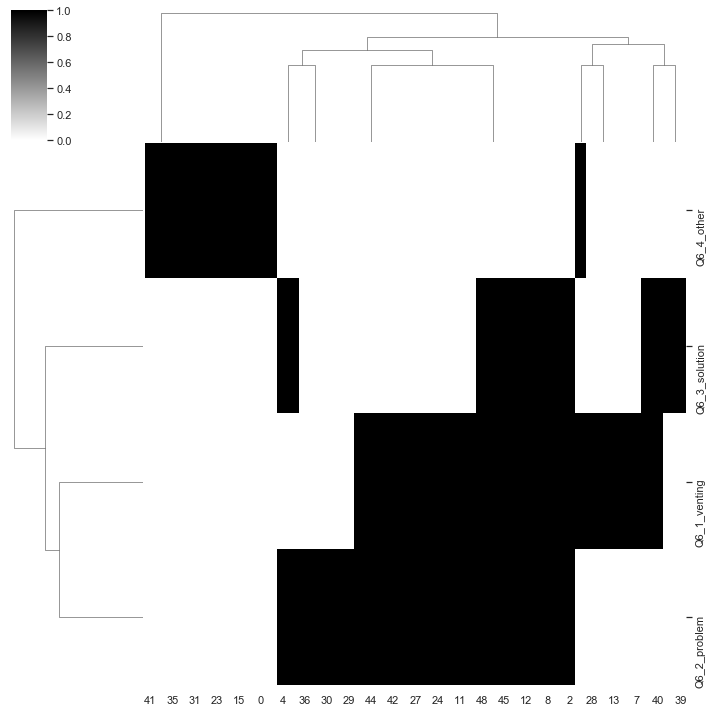

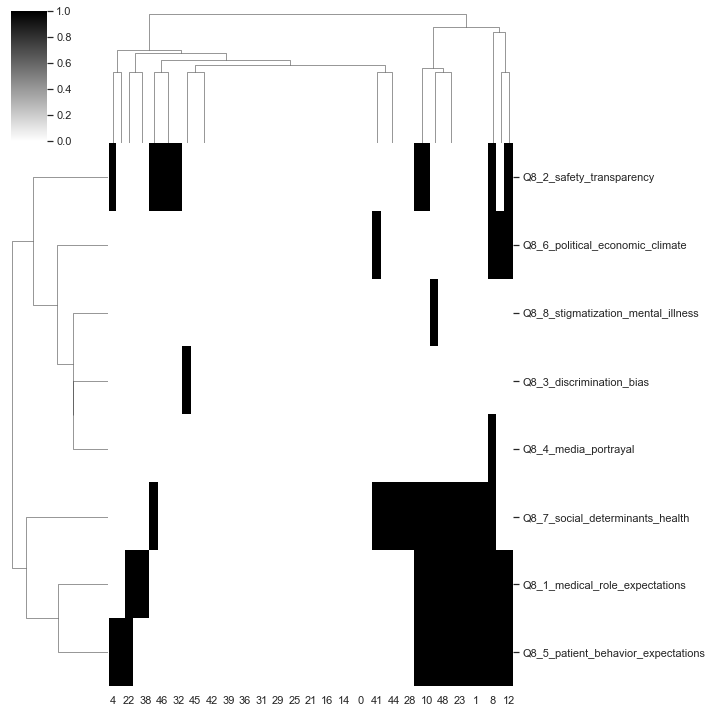

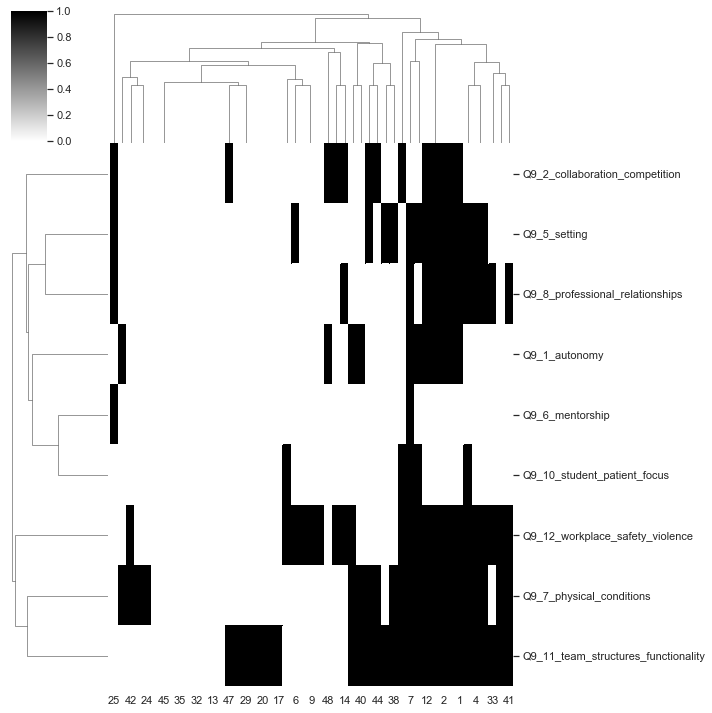

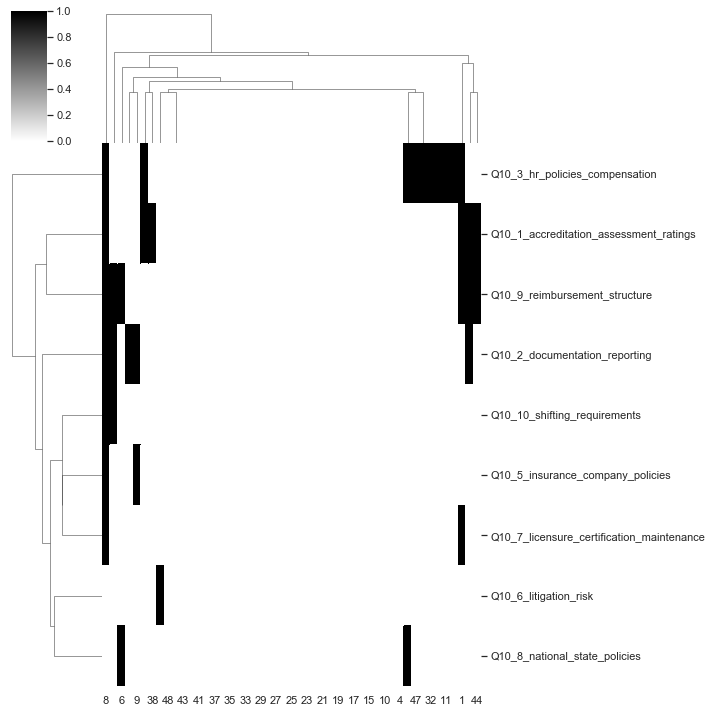

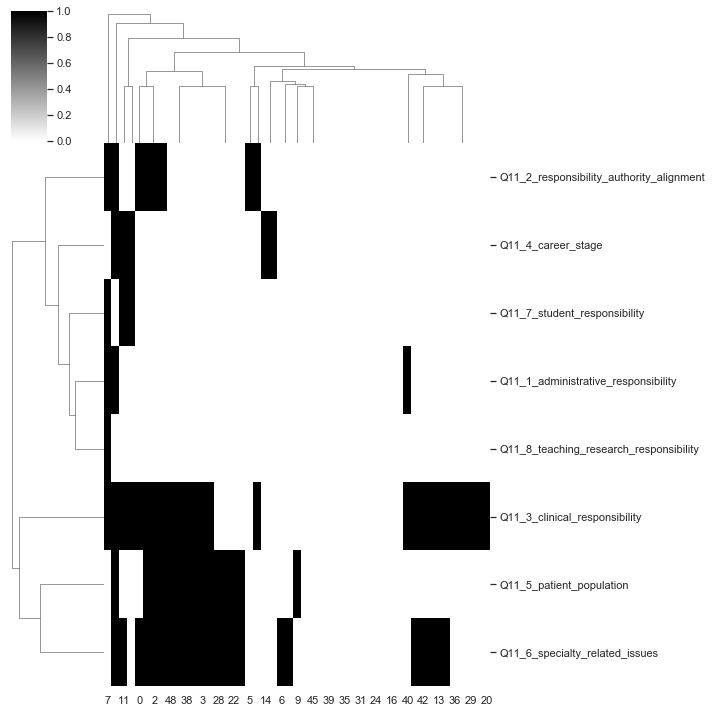

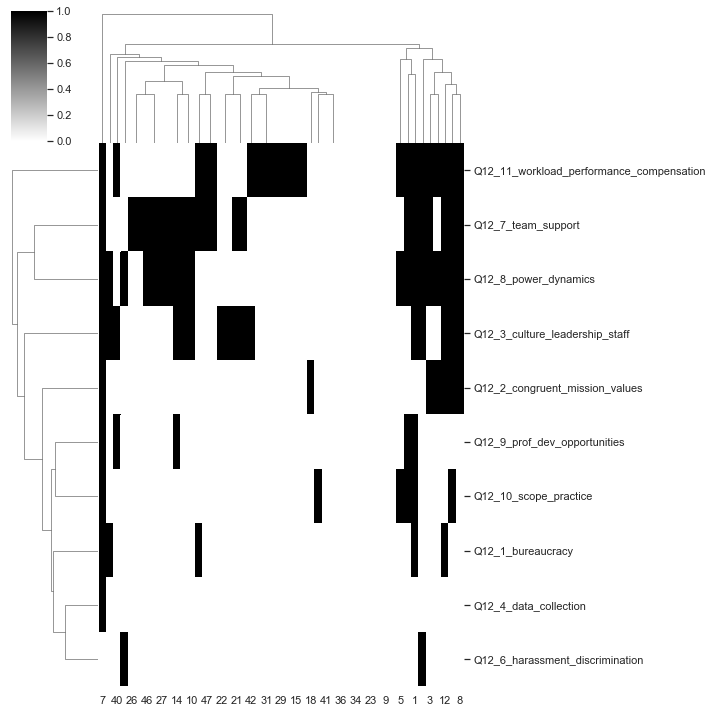

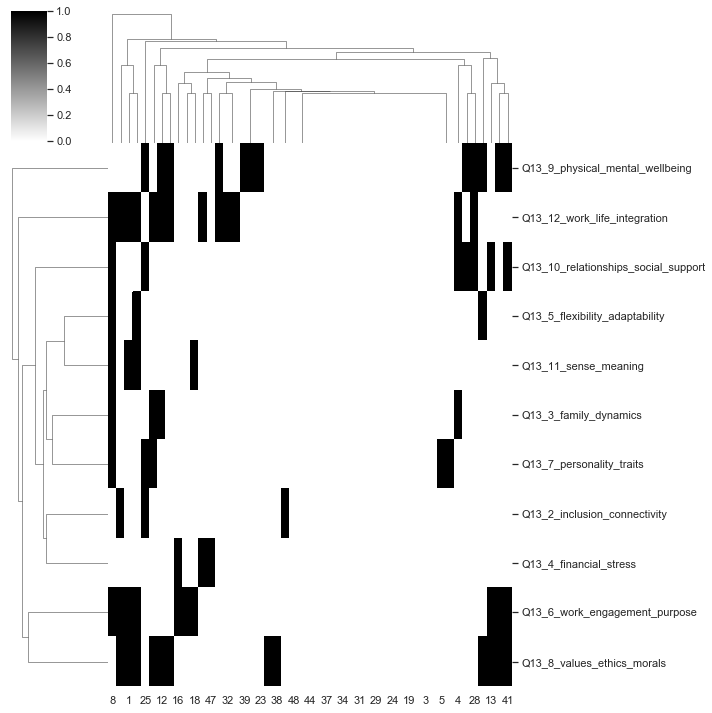

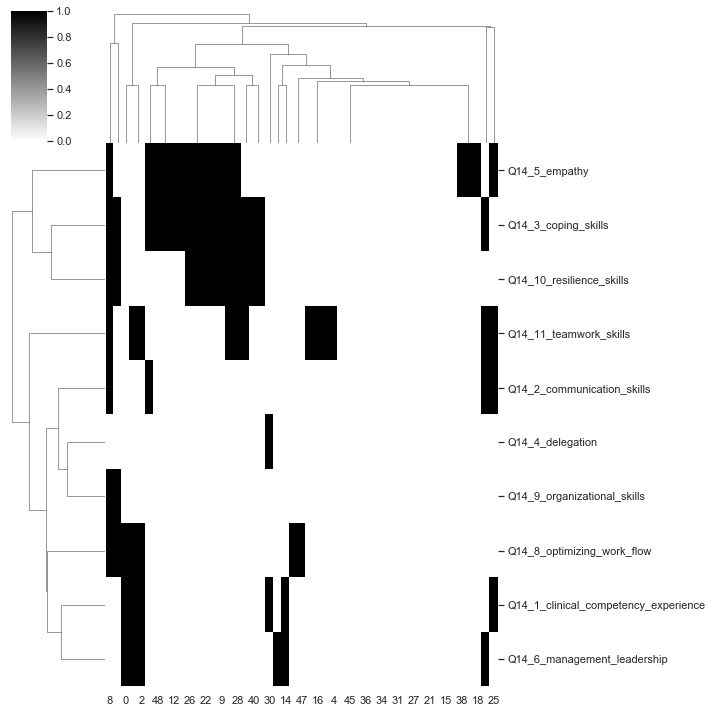

In [14]:
for group in indicator_col_groups:
    sns.clustermap(engage_data_one[group].transpose(),row_cluster=True, col_cluster=True, cmap='binary')

In [15]:
ind_data_one = engage_data_one[[item for group in indicator_col_groups for item in group]]

In [16]:
print('Rows:',len(ind_data_one))
print('Columns:',len(ind_data_one.columns))
ind_data_one.head()

Rows: 49
Columns: 69


,Q6_1_venting,Q6_2_problem,Q6_3_solution,Q6_4_other,Q8_1_medical_role_expectations,Q8_2_safety_transparency,Q8_3_discrimination_bias,Q8_4_media_portrayal,Q8_5_patient_behavior_expectations,Q8_6_political_economic_climate,Q8_7_social_determinants_health,Q8_8_stigmatization_mental_illness,Q9_1_autonomy,Q9_2_collaboration_competition,Q9_5_setting,Q9_6_mentorship,Q9_7_physical_conditions,Q9_8_professional_relationships,Q9_10_student_patient_focus,Q9_11_team_structures_functionality,Q9_12_workplace_safety_violence,Q10_1_accreditation_assessment_ratings,Q10_2_documentation_reporting,Q10_3_hr_policies_compensation,Q10_5_insurance_company_policies,Q10_6_litigation_risk,Q10_7_licensure_certification_maintenance,Q10_8_national_state_policies,Q10_9_reimbursement_structure,Q10_10_shifting_requirements,Q11_1_administrative_responsibility,Q11_2_responsibility_authority_alignment,Q11_3_clinical_responsibility,Q11_4_career_stage,Q11_5_patient_population,Q11_6_specialty_related_issues,Q11_7_student_responsibility,Q11_8_teaching_research_responsibility,Q12_1_bureaucracy,Q12_2_congruent_mission_values,Q12_3_culture_leadership_staff,Q12_4_data_collection,Q12_6_harassment_discrimination,Q12_7_team_support,Q12_8_power_dynamics,Q12_9_prof_dev_opportunities,Q12_10_scope_practice,Q12_11_workload_performance_compensation,Q13_2_inclusion_connectivity,Q13_3_family_dynamics,Q13_4_financial_stress,Q13_5_flexibility_adaptability,Q13_6_work_engagement_purpose,Q13_7_personality_traits,Q13_8_values_ethics_morals,Q13_9_physical_mental_wellbeing,Q13_10_relationships_social_support,Q13_11_sense_meaning,Q13_12_work_life_integration,Q14_1_clinical_competency_experience,Q14_2_communication_skills,Q14_3_coping_skills,Q14_4_delegation,Q14_5_empathy,Q14_6_management_leadership,Q14_8_optimizing_work_flow,Q14_9_organizational_skills,Q14_10_resilience_skills,Q14_11_teamwork_skills
0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1
2,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1
3,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1


In [17]:
ind_data_one.sum(axis=0).head(10)

Q6_1_venting                          28
Q6_2_problem                          27
Q6_3_solution                         15
Q6_4_other                            13
Q8_1_medical_role_expectations        15
Q8_2_safety_transparency               9
Q8_3_discrimination_bias               1
Q8_4_media_portrayal                   1
Q8_5_patient_behavior_expectations    15
Q8_6_political_economic_climate        4
dtype: int64

In [18]:
ind_data_one.sum(axis=1).value_counts()

13    5
7     5
15    4
9     3
11    3
17    3
5     3
3     3
2     2
16    2
14    2
6     2
10    1
4     1
23    1
8     1
38    1
32    1
22    1
25    1
45    1
37    1
35    1
12    1
dtype: int64

In [19]:
save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data1_themes_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_one.to_csv(save_name)

save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data1_themes_totals_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_one.sum(axis=0).to_csv(save_name)

save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data1_themes_respondentTotals_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_one.sum(axis=1).to_csv(save_name)

In [20]:
ind_data_one

,Q6_1_venting,Q6_2_problem,Q6_3_solution,Q6_4_other,Q8_1_medical_role_expectations,Q8_2_safety_transparency,Q8_3_discrimination_bias,Q8_4_media_portrayal,Q8_5_patient_behavior_expectations,Q8_6_political_economic_climate,Q8_7_social_determinants_health,Q8_8_stigmatization_mental_illness,Q9_1_autonomy,Q9_2_collaboration_competition,Q9_5_setting,Q9_6_mentorship,Q9_7_physical_conditions,Q9_8_professional_relationships,Q9_10_student_patient_focus,Q9_11_team_structures_functionality,Q9_12_workplace_safety_violence,Q10_1_accreditation_assessment_ratings,Q10_2_documentation_reporting,Q10_3_hr_policies_compensation,Q10_5_insurance_company_policies,Q10_6_litigation_risk,Q10_7_licensure_certification_maintenance,Q10_8_national_state_policies,Q10_9_reimbursement_structure,Q10_10_shifting_requirements,Q11_1_administrative_responsibility,Q11_2_responsibility_authority_alignment,Q11_3_clinical_responsibility,Q11_4_career_stage,Q11_5_patient_population,Q11_6_specialty_related_issues,Q11_7_student_responsibility,Q11_8_teaching_research_responsibility,Q12_1_bureaucracy,Q12_2_congruent_mission_values,Q12_3_culture_leadership_staff,Q12_4_data_collection,Q12_6_harassment_discrimination,Q12_7_team_support,Q12_8_power_dynamics,Q12_9_prof_dev_opportunities,Q12_10_scope_practice,Q12_11_workload_performance_compensation,Q13_2_inclusion_connectivity,Q13_3_family_dynamics,Q13_4_financial_stress,Q13_5_flexibility_adaptability,Q13_6_work_engagement_purpose,Q13_7_personality_traits,Q13_8_values_ethics_morals,Q13_9_physical_mental_wellbeing,Q13_10_relationships_social_support,Q13_11_sense_meaning,Q13_12_work_life_integration,Q14_1_clinical_competency_experience,Q14_2_communication_skills,Q14_3_coping_skills,Q14_4_delegation,Q14_5_empathy,Q14_6_management_leadership,Q14_8_optimizing_work_flow,Q14_9_organizational_skills,Q14_10_resilience_skills,Q14_11_teamwork_skills
0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,1,0,0,0
1,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,0,1,0,0,1,0,1,0,1,1,1,1,1,1,0,0,1,0,1,0,0,1,1,1,1,1,0,0,0,0,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1
2,1,1,1,0,1,0,0,0,1,0,1,0,1,1,1,0,1,1,0,1,1,1,1,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,1,1,0,0,0,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,0,1
3,1,0,0,0,1,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,0,1,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1
5,0,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,1,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,1,0,0,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0
7,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,0,0,0,1,1,0,0,0,1,0,1,1,0,0,1,0,0,0,1
8,1,1,1,0,1,1,0,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,1,0,1,1,0,1,1,0,0,0,1,1,0,0,1,1,0,0,1,0,1,0,1,1,1,0,0,1,1,1,0,1,1,0,1,0,1,1,1,1
9,0,0,0,1,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0


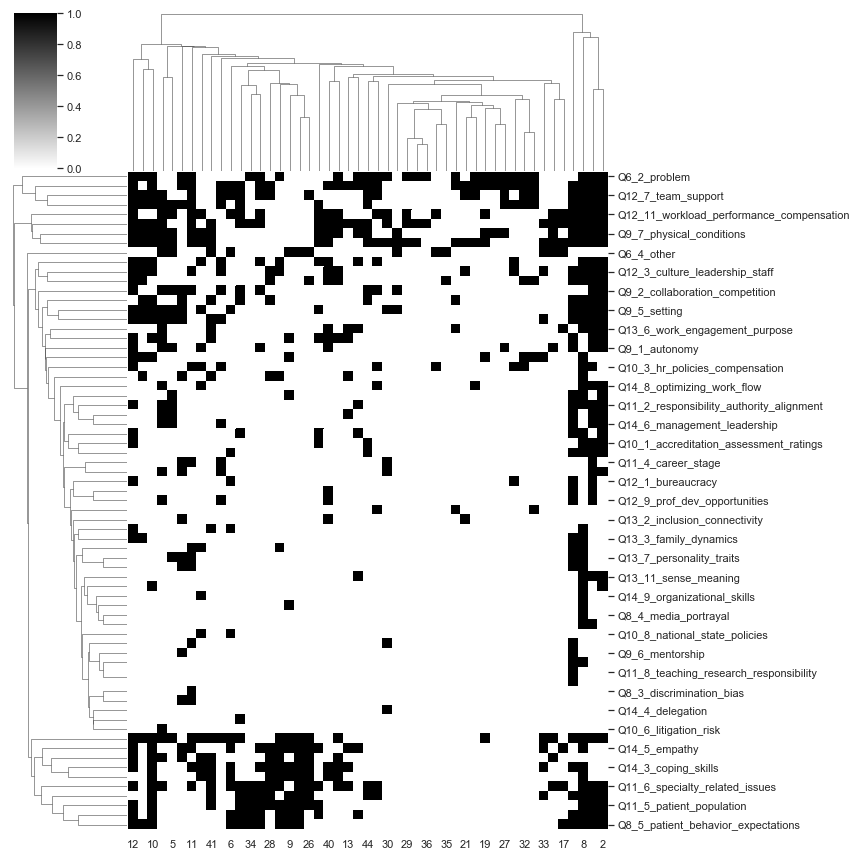

In [21]:
sns.clustermap(ind_data_one.transpose(),figsize=(12,12),row_cluster=True, col_cluster=True, cmap='binary')

## Data Collection 2

### Column names and labels

In [22]:
engage_data_two = pd.read_csv(RAW_ENGAGEMENT_PATH + 'bc_ew_data_two.csv')

# Initial cols
col_names_dict = {'StartDate':'start_date','EndDate':'end_date','Status':'status','IPAddress':'ip_addr',
                 'Progress':'progress','Duration (in seconds)':'duration_seconds','Finished':'finished',
                 'RecordedDate':'record_date','ResponseId':'response_id','RecipientLastName':'recip_last_name',
                 'RecipientFirstName':'recip_first_name','RecipientEmail':'recip_email','ExternalReference':'ext_ref',
                 'LocationLatitude':'loc_lat','LocationLongitude':'loc_long','DistributionChannel':'dist_channel',
                 'UserLanguage':'recip_language'}
col_labels_dict = dict(engage_data_two.iloc[0,0:17])

# Question cols
q_keys_two = engage_data_two.iloc[0,17:].index.to_list()
q_keys_stripped_two = [item.replace('_TEXT','') for item in engage_data_two.iloc[0,17:].index.to_list()]
q_names_two = ['date','listener','listener_text','location','location_text','name','role','role_text',
               'venting','problem','solution','affirmation',
               'notes','needs_requests','is_actionable','is_actionable_text','loudness_score',
               'basic_needs_operational','basic_needs_personal','physical_space_clinicians','physical_space_processing','role_inclusivity_value','emotional_labor_value','team_dynamics','clinical_debriefing_learning','physical_safety','leadership_dynamics','trauma_moral_distress','dept_resources','misinterpreted_overused_metrics','other','other_text']
q_values_two = ['_'.join(item) for item in zip(q_keys_stripped_two,q_names_two)]
q_names_dict_two = dict(zip(q_keys_two,q_values_two))
q_labels_dict_two = dict(engage_data_two.iloc[0,17:])
q_groups_dict_two = {'Q20':'Conversation Type','Q19':'Themes'}

# Rename columns 
engage_data_two = engage_data_two.rename(columns=col_names_dict)
engage_data_two = engage_data_two.rename(columns=q_names_dict_two)

# Remove label row, drop empty cols
engage_data_two = engage_data_two.iloc[1:].reset_index(drop=True)
engage_data_two = engage_data_two.dropna(how='all',axis=1)

### Column values

In [23]:
# Define col types
date_cols_two = ['start_date','end_date','record_date','Q1_date']
text_cols_two = ['Q2_listener','Q3_location','Q4_name','Q5_role','Q15_notes','Q18_needs_requests','Q22_1_is_actionable_text','Q19_10_other_text']
indicator_cols_two = ['Q20_1_venting','Q20_2_problem','Q20_3_solution','Q20_4_affirmation',
                      'Q19_1_basic_needs_operational','Q19_2_basic_needs_personal','Q19_3_physical_space_clinicians','Q19_4_physical_space_processing','Q19_5_role_inclusivity_value','Q19_6_emotional_labor_value','Q19_8_team_dynamics','Q19_9_clinical_debriefing_learning','Q19_11_physical_safety','Q19_12_leadership_dynamics','Q19_13_trauma_moral_distress','Q19_14_dept_resources','Q19_15_misinterpreted_overused_metrics','Q19_10_other']
yes_no_cols_two = ['Q22_is_actionable']
num_cols_two = ['Q21_loudness_score']
indicator_col_groups_two = [[col for col in indicator_cols_two if key in col] for key in q_groups_dict_two.keys()]

# Set date cols
for col in date_cols_two:
    engage_data_two[col] = pd.to_datetime(engage_data_two[col])
    
# Pre-clean text cols
for col in text_cols_two:
    engage_data_two[col] = engage_data_two[col].str.strip()
    engage_data_two[col] = engage_data_two[col].str.lower()

# Adjust indicator cols
indicator_col_labels_two = []
for col in indicator_cols_two:
    indicator_col_labels_two.append([col,engage_data_two[col].unique()[-1]])
    engage_data_two[col] = engage_data_two[col].apply(lambda x: 0 if pd.isnull(x) else 1)
indicator_col_labels_dict_two = dict(indicator_col_labels_two)

# Adjust yes/no cols
for col in yes_no_cols_two:
    engage_data_two[col] = engage_data_two[col].apply(lambda x: 1 if x=='Yes' else 0)

# Adjust num cols
for col in num_cols_two:
    engage_data_two[col] = engage_data_two[col].fillna(0)

### Display data

In [ ]:
print('Rows:',len(engage_data_two))
print('Columns:',len(engage_data_two.columns))
engage_data_two.head()

In [25]:
save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data2_master)' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
engage_data_two.to_csv(save_name)

In [26]:
engage_data_two[indicator_col_groups_two[0]]

,Q20_1_venting,Q20_2_problem,Q20_3_solution,Q20_4_affirmation
0,1,1,1,1
1,0,1,0,0
2,0,1,0,1
3,1,1,0,0
4,1,1,0,0
5,0,1,0,0
6,1,0,0,0
7,0,0,1,1
8,1,1,0,0
9,1,1,1,1


In [27]:
engage_data_two[indicator_col_groups_two[0]].sum(axis=0)

Q20_1_venting        19
Q20_2_problem        20
Q20_3_solution       15
Q20_4_affirmation     7
dtype: int64

In [28]:
engage_data_two[indicator_col_groups_two[0]].sum(axis=1)

0     4
1     1
2     2
3     2
4     2
5     1
6     1
7     2
8     2
9     4
10    3
11    2
12    2
13    3
14    3
15    3
16    1
17    3
18    1
19    1
20    3
21    3
22    3
23    3
24    3
25    3
dtype: int64

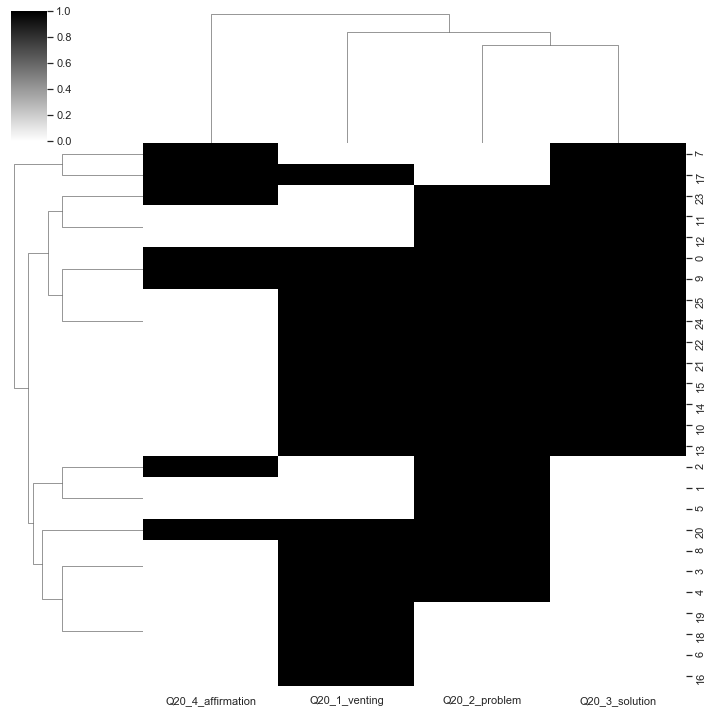

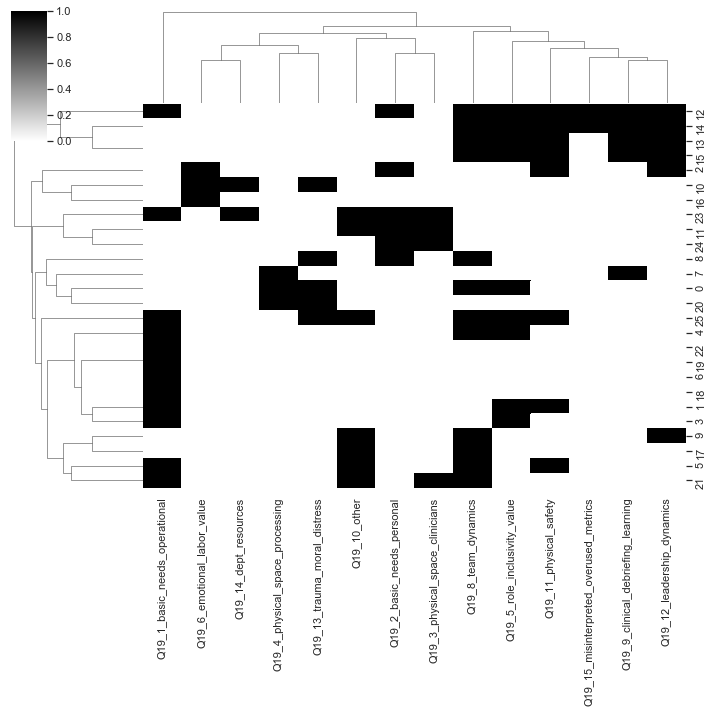

In [29]:
for group in indicator_col_groups_two:
    sns.clustermap(engage_data_two[group],row_cluster=True, col_cluster=True, cmap='binary')

In [30]:
ind_data_two = engage_data_two[[item for group in indicator_col_groups_two for item in group]]

In [31]:
print('Rows:',len(ind_data_two))
print('Columns:',len(ind_data_two.columns))
ind_data_two.head()

Rows: 26
Columns: 18


,Q20_1_venting,Q20_2_problem,Q20_3_solution,Q20_4_affirmation,Q19_1_basic_needs_operational,Q19_2_basic_needs_personal,Q19_3_physical_space_clinicians,Q19_4_physical_space_processing,Q19_5_role_inclusivity_value,Q19_6_emotional_labor_value,Q19_8_team_dynamics,Q19_9_clinical_debriefing_learning,Q19_11_physical_safety,Q19_12_leadership_dynamics,Q19_13_trauma_moral_distress,Q19_14_dept_resources,Q19_15_misinterpreted_overused_metrics,Q19_10_other
0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0
3,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0


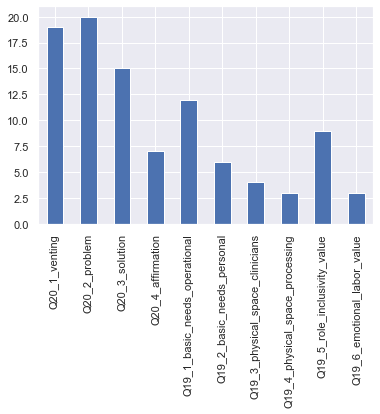

In [32]:
ind_data_two.sum(axis=0).head(10).plot(kind='bar')

In [33]:
ind_data_two.sum(axis=1).value_counts()

5     7
8     4
4     4
2     4
6     2
7     2
9     2
10    1
dtype: int64

In [34]:
save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data2_themes_master_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_two.to_csv(save_name)

save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data2_themes_totals_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_two.sum(axis=0).to_csv(save_name)

save_name = MASTER_ENGAGEMENT_PATH + 'bc_ew_data2_themes_respondentTotals_' + str(datetime.datetime.now().date()).replace('-','') + '.csv'
ind_data_two.sum(axis=1).to_csv(save_name)

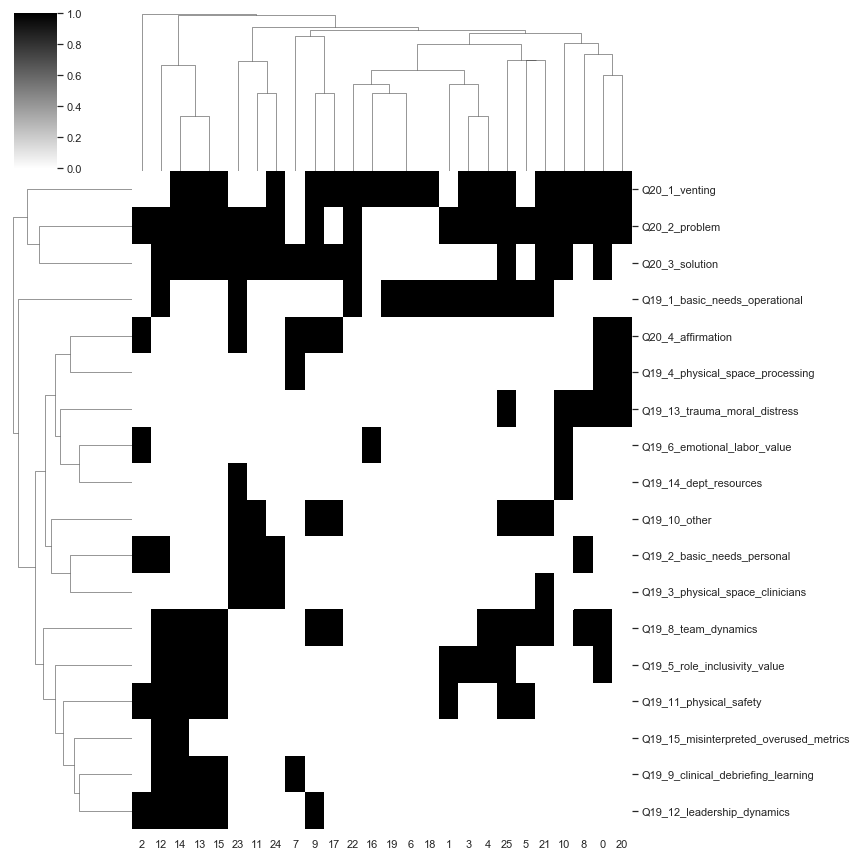

In [35]:
sns.clustermap(ind_data_two.transpose(),figsize=(12,12),row_cluster=True, col_cluster=True, cmap='binary')

In [ ]:
print(len(engage_data_two))
print(len(engage_data_two.columns))
engage_data_two.head()

In [93]:
print(len(ind_data_two))
print(len(ind_data_two.columns))
ind_data_two.head()

26
18


,Q20_1_venting,Q20_2_problem,Q20_3_solution,Q20_4_affirmation,Q19_1_basic_needs_operational,Q19_2_basic_needs_personal,Q19_3_physical_space_clinicians,Q19_4_physical_space_processing,Q19_5_role_inclusivity_value,Q19_6_emotional_labor_value,Q19_8_team_dynamics,Q19_9_clinical_debriefing_learning,Q19_11_physical_safety,Q19_12_leadership_dynamics,Q19_13_trauma_moral_distress,Q19_14_dept_resources,Q19_15_misinterpreted_overused_metrics,Q19_10_other
0,1,1,1,1,0,0,0,1,1,0,1,0,0,0,1,0,0,0
1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0,1,0,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0
3,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0


[Text(0, 0, 'Venting'),
 Text(0, 0, 'Problem'),
 Text(0, 0, 'Team\nstructures\nfunctionality'),
 Text(0, 0, 'Clinical\nresponsibility'),
 Text(0, 0, 'Specialty\nrelated\nissues'),
 Text(0, 0, 'Workplace\nsafety\nviolence'),
 Text(0, 0, 'Physical\nconditions'),
 Text(0, 0, 'Workload\nperformance\ncompensation'),
 Text(0, 0, 'Team\nsupport'),
 Text(0, 0, 'Power\ndynamics'),
 Text(0, 0, 'Coping\nskills'),
 Text(0, 0, 'Empathy'),
 Text(0, 0, 'Culture\nleadership\nstaff'),
 Text(0, 0, 'Social\ndeterminants\nhealth'),
 Text(0, 0, 'Patient\npopulation'),
 Text(0, 0, 'Patient\nbehavior\nexpectations'),
 Text(0, 0, 'Solution'),
 Text(0, 0, 'Medical\nrole\nexpectations'),
 Text(0, 0, 'Setting'),
 Text(0, 0, 'Professional\nrelationships')]

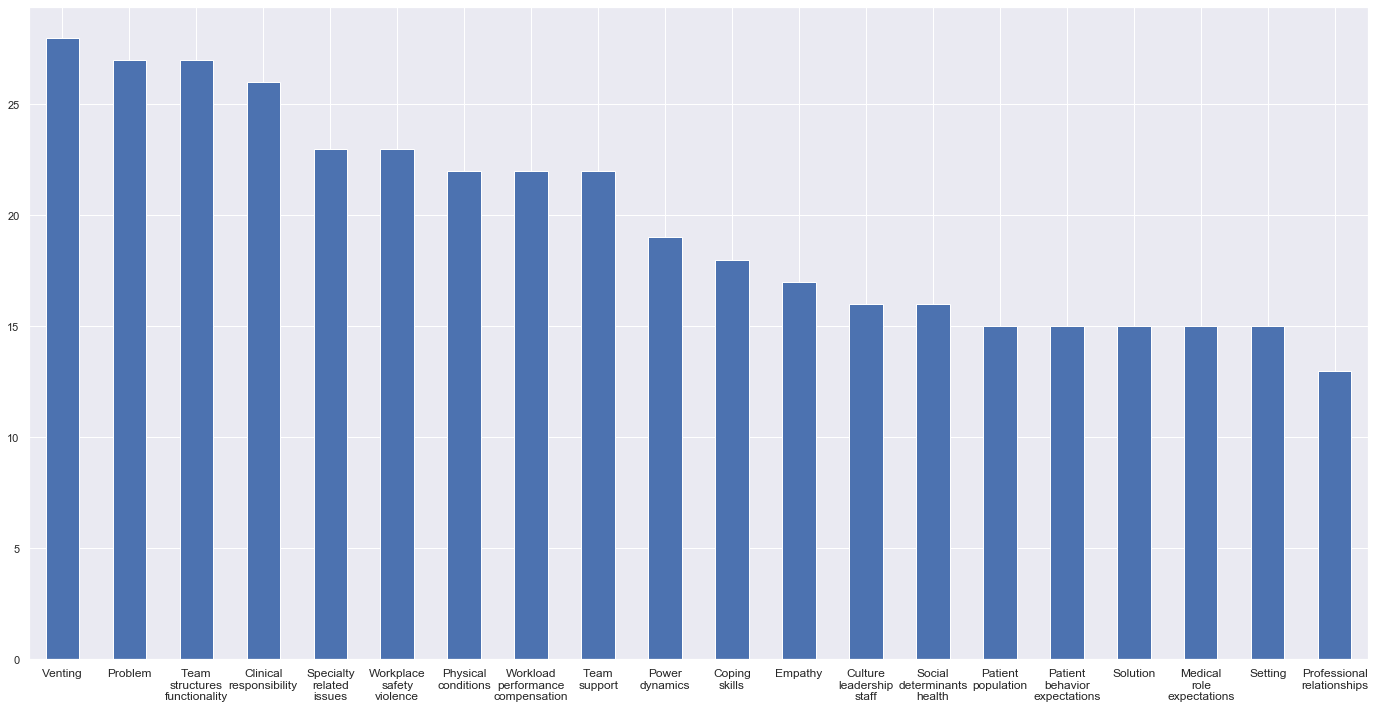

In [85]:
temp_1 = ind_data_one.sum()
temp_1.index = ['\n'.join(item.split('_')[2:]).capitalize() for item in temp_1.index]
a = temp_1.sort_values(ascending=False).head(20).plot(figsize=(24,12),kind='bar')
a.set_xticklabels(a.get_xticklabels(), rotation=0, fontsize=12)

[Text(0, 0, 'Problem'),
 Text(0, 0, 'Venting'),
 Text(0, 0, 'Solution'),
 Text(0, 0, 'Basic\nneeds\noperational'),
 Text(0, 0, 'Team\ndynamics'),
 Text(0, 0, 'Role\ninclusivity\nvalue'),
 Text(0, 0, 'Physical\nsafety'),
 Text(0, 0, 'Other'),
 Text(0, 0, 'Affirmation'),
 Text(0, 0, 'Basic\nneeds\npersonal'),
 Text(0, 0, 'Leadership\ndynamics'),
 Text(0, 0, 'Clinical\ndebriefing\nlearning'),
 Text(0, 0, 'Trauma\nmoral\ndistress'),
 Text(0, 0, 'Physical\nspace\nclinicians'),
 Text(0, 0, 'Physical\nspace\nprocessing'),
 Text(0, 0, 'Emotional\nlabor\nvalue'),
 Text(0, 0, 'Dept\nresources'),
 Text(0, 0, 'Misinterpreted\noverused\nmetrics')]

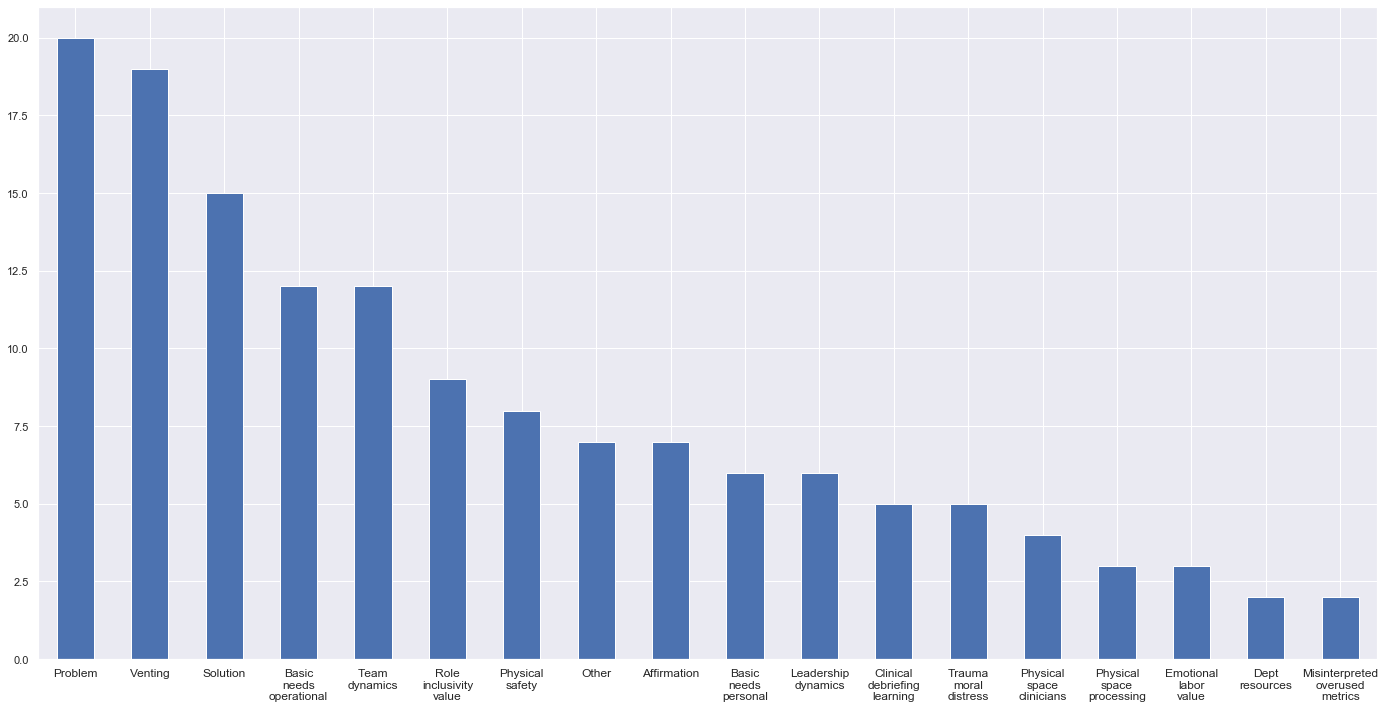

In [87]:
temp_2 = ind_data_two.sum()
temp_2.index = ['\n'.join(item.split('_')[2:]).capitalize() for item in temp_2.index]
a = temp_2.sort_values(ascending=False).head(20).plot(figsize=(24,12),kind='bar')
a.set_xticklabels(a.get_xticklabels(), rotation=0, fontsize=12)

# Unused / Deprecated Code
* For old ideas that could be useful later!

In [ ]:
"""

old_col_labels = engage_data_one.columns[0:17]
new_col_labels = [' '.join(re.findall('[A-Z][^A-Z]*', item)) for item in engage_data_one.columns[0:17]]
col_label_dict = dict(zip(old_col_labels,new_col_labels))

"""